# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import re
import pickle
import numpy as np
import pandas as pd

# import nltk
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# import classfiers
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# import feature extraction, pipeline and model selection tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
%matplotlib inline

import timeit

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql_table('desaster_tweets', engine)
X = df['message']
y = df.drop(columns = ['id', 'message', 'original', 'genre'])

Let's have a look at the labels distribution.

In [3]:
y.describe(include = 'all')

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,...,26028.000000,26028.000000,26028.000000,26028.000000,26028.00000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000
mean,0.764792,0.171892,0.004534,0.417243,0.080068,0.050446,0.027816,0.018096,0.033041,0.064239,...,0.011872,0.044222,0.280352,0.082795,0.09386,0.010834,0.094321,0.020363,0.052866,0.194982
std,0.424137,0.377294,0.067180,0.493113,0.271403,0.218867,0.164449,0.133301,0.178748,0.245182,...,0.108311,0.205591,0.449180,0.275578,0.29164,0.103525,0.292281,0.141240,0.223771,0.396195
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


Distribution of categories is unbalanced. This means that accuracy is not suitable as performance score. In this notebook precision, recall and f1 score will be used with macro averaging method to evaluate model predictions. Macro averaging means the scores for all labels are avaraged with the same weights as if the distribution was uniform.

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text): 
    # remove non-letter characters
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())
    # tokenize
    tokens = word_tokenize(text)
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
 
    return clean_tokens

In [5]:
class NounsExtractor(BaseEstimator, TransformerMixin):

    def get_nouns(self, text):
        sentence_list = nltk.sent_tokenize(text)
        nouns =[]
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            nouns = nouns + [word.lower() for word,pos in pos_tags if pos == 'NN']
        return ' '.join(nouns)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.get_nouns)
        return X_tagged

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [6]:
def build_cv(pipeline, parameters):

    # create grid search object
    cv = GridSearchCV(pipeline, param_grid = parameters, verbose = 5, n_jobs = -1, scoring = 'f1_macro', refit = True,
                     return_train_score = False)
    
    return cv

In [19]:
def show_results(y_test, y_pred, print_report):
    f1 = []
    prcs = []
    recl = []
    rocauc = []
    for i, label in enumerate(y.columns):
        true = y_test[label].values
        pred = y_pred[label].values
        if print_report:
            print('Classification result for category \"{}\":'.format(label))
            print(classification_report(true, pred))
        f1.append((f1_score(true, pred, average = 'macro')))
        prcs.append(precision_score(true, pred, average = 'macro'))
        recl.append(recall_score(true, pred, average = 'macro'))
        rocauc.append(roc_auc_score(true, pred, average = 'macro'))

    return (pd.DataFrame.from_dict({'label':y.columns, 'precision':prcs, 'recall':recl, 'f1':f1, 'roc_auc':rocauc}))

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

#### 4.1. Train "related" classifier

During data analysis it was shown that only messages which are labeled "related" contain other labels as well. One approach would be the following:
- First classfier will be trained for "related" label. This feature also has higher importance as it helps to filter out messages related to disaster.

- Second classifier will be trained for remaining labels to identify different labels for the categories based on experience with "related" classifier .

The "related" column is right-heavy:

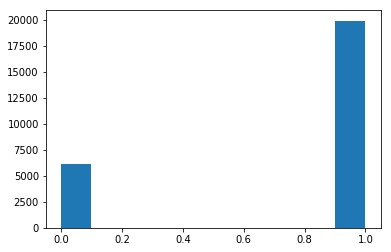

In [9]:
plt.hist(df['related']);

Dealing with imbalanced classes is complicated. To compensate for imbalance a function will be introduced to simply pad the underrepresented class until the proportion of minority class is in desired range.

In [10]:
def padToBalance(X, y):
    # find minority class
    if((y.sum() / y.shape[0]) > 0.5):
        minority = 0
    else:
        minority = 1
    # initialize outputs
    X_bal = X
    y_bal = y
    # pad the data until minority class is at least 25%
    while((y_bal == minority).sum() < 0.25 * y.shape[0]):
        X_bal = pd.concat([X_bal, X[y == minority]])
        y_bal = pd.concat([y_bal, y[y == minority]])
    
    return X_bal, y_bal

In [11]:
X_train_bal, y_train_bal = padToBalance(X_train, y_train['related'])

MLPC_pipeline = Pipeline([
    #('noun', NounsExtractor()),
    ('vect', CountVectorizer(tokenizer = tokenize)),
    #('tfidf', TfidfTransformer()),
    ('clf', MLPClassifier(activation='relu', alpha=0.001, batch_size=200, beta_1=0.9,
                           beta_2=0.999, early_stopping=True, epsilon=1e-8,
                           hidden_layer_sizes=(55), learning_rate='constant',
                           learning_rate_init=0.001, max_iter=200, momentum=0.9,
                           nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
                           solver='adam', tol=0.01, validation_fraction=0.1, verbose=True,
                           warm_start=False))
])

MLPC_pipeline.fit(X_train_bal, y_train_bal)

Iteration 1, loss = 0.49261090
Validation score: 0.844463
Iteration 2, loss = 0.30770320
Validation score: 0.869764
Iteration 3, loss = 0.22575626
Validation score: 0.880962
Iteration 4, loss = 0.17538118
Validation score: 0.883036
Iteration 5, loss = 0.14188785
Validation score: 0.887599
Iteration 6, loss = 0.11959376
Validation score: 0.885525
Validation score did not improve more than tol=0.010000 for two consecutive epochs. Stopping.


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...e,
       solver='adam', tol=0.01, validation_fraction=0.1, verbose=True,
       warm_start=False))])

In [12]:
y_pred = MLPC_pipeline.predict(X_test)
true = y_test['related'].values
pred = np.squeeze(y_pred)
print(classification_report(true, pred))

             precision    recall  f1-score   support

          0       0.60      0.65      0.62      1540
          1       0.89      0.87      0.88      4967

avg / total       0.82      0.82      0.82      6507



In [13]:
print('ROC AUC score (macro-averaged)', roc_auc_score(true, pred, average = 'macro'))
print('F1 score (macro-averaged)', f1_score(true, pred, average = 'macro'))

ROC AUC score (macro-averaged) 0.757396086901
F1 score (macro-averaged) 0.75150687524


In [14]:
MLPC_pipeline.named_steps['clf']

MLPClassifier(activation='relu', alpha=0.001, batch_size=200, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=55, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.01, validation_fraction=0.1, verbose=True,
       warm_start=False)

#### 4.2. Training categories classifiers

Training data needs to be balanced. Instead of a multi-output classifier we will use a dictionary of pipelines.

In [15]:
MLPC_pipeline_dict = {}
countvec = CountVectorizer(tokenizer = tokenize)
start = timeit.default_timer()
for i,label in enumerate(y.columns):
    MLPC_pipeline_dict[label] = Pipeline([
        ('vect', countvec),
        ('clf',MLPClassifier(activation='relu', alpha=0.001, batch_size=200, beta_1=0.9,
                               beta_2=0.999, early_stopping=True, epsilon=1e-08,
                               hidden_layer_sizes=55, learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200, momentum=0.9,
                               nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
                               solver='adam', tol=0.01, validation_fraction=0.1, verbose=True,
                               warm_start=False))
    ])
    print('Training classifier {} of {} for \"{}\"'.format(i, len(y.columns), label))
    X_train_bal, y_train_bal = padToBalance(X_train, y_train[label])
    print(y_train_bal.sum()/y_train_bal.shape[0])
    MLPC_pipeline_dict[label].fit(X_train_bal, y_train_bal)
stop = timeit.default_timer()

MLPC_training_time = stop - start

Training classifier 0 of 35 for "related"
0.619798365349
Iteration 1, loss = 0.49261090
Validation score: 0.844463
Iteration 2, loss = 0.30770320
Validation score: 0.869764
Iteration 3, loss = 0.22575626
Validation score: 0.880962
Iteration 4, loss = 0.17538118
Validation score: 0.883036
Iteration 5, loss = 0.14188785
Validation score: 0.887599
Iteration 6, loss = 0.11959376
Validation score: 0.885525
Validation score did not improve more than tol=0.010000 for two consecutive epochs. Stopping.
Training classifier 1 of 35 for "request"
0.293245901639
Iteration 1, loss = 0.44244321
Validation score: 0.884615
Iteration 2, loss = 0.27639467
Validation score: 0.893794
Iteration 3, loss = 0.20483071
Validation score: 0.899476
Iteration 4, loss = 0.16200403
Validation score: 0.912150
Iteration 5, loss = 0.13456145
Validation score: 0.916084
Iteration 6, loss = 0.11307846
Validation score: 0.920455
Iteration 7, loss = 0.09763643
Validation score: 0.923951
Validation score did not improve more 

Iteration 5, loss = 0.14864432
Validation score: 0.877431
Iteration 6, loss = 0.11267283
Validation score: 0.899593
Iteration 7, loss = 0.08864842
Validation score: 0.897784
Iteration 8, loss = 0.07052243
Validation score: 0.901854
Iteration 9, loss = 0.06089795
Validation score: 0.903211
Validation score did not improve more than tol=0.010000 for two consecutive epochs. Stopping.
Training classifier 18 of 35 for "infrastructure_related"
0.217879489157
Iteration 1, loss = 0.50418777
Validation score: 0.844901
Iteration 2, loss = 0.28136624
Validation score: 0.916024
Iteration 3, loss = 0.15907674
Validation score: 0.946444
Iteration 4, loss = 0.09737645
Validation score: 0.965296
Iteration 5, loss = 0.06479439
Validation score: 0.968723
Iteration 6, loss = 0.04778471
Validation score: 0.971722
Iteration 7, loss = 0.03429413
Validation score: 0.977292
Validation score did not improve more than tol=0.010000 for two consecutive epochs. Stopping.
Training classifier 19 of 35 for "transport

Iteration 4, loss = 0.19034169
Validation score: 0.887173
Iteration 5, loss = 0.15717297
Validation score: 0.892750
Iteration 6, loss = 0.13302557
Validation score: 0.900043
Iteration 7, loss = 0.11480388
Validation score: 0.894895
Validation score did not improve more than tol=0.010000 for two consecutive epochs. Stopping.


In [41]:
print('MLCP pipeline training time: {:.2f} seconds'.format(MLPC_training_time))

MLCP pipeline training time: 1672.25 seconds


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [18]:
MLPC_pipeline_pred_dict = {}
start = timeit.default_timer()
for label in y.columns:
    MLPC_pipeline_pred_dict[label] = MLPC_pipeline_dict[label].predict(X_test)
stop = timeit.default_timer()
MLPC_predict_time = stop - start
    
y_pred = pd.DataFrame.from_dict(MLPC_pipeline_pred_dict)
results_MLPC = show_results(y_test, y_pred, print_report = False)
results_MLPC.mean()

precision    0.706208
recall       0.659678
f1           0.676563
rpc_auc      0.659678
dtype: float64

In [31]:
print('MLCP pipeline predict time: {:.2f} seconds'.format(MLPC_predict_time))

MLCP pipeline predict time: 104.12 seconds


### 6. Improve your model
Use grid search to find better parameters. 

Grid search is computationally expensive, so it would be very time consuming to perform it on a multi output model. Also evaluation of multiple classifications will be complex. Instead grid search was applied to the "related" column in the section 4.1 to fine-tune MLPC parameters.

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [34]:
show_results(y_test, y_pred, print_report = False)

,label,precision,recall,f1,roc_auc
0,related,0.746369,0.757396,0.751507,0.757396
1,request,0.796231,0.792444,0.794314,0.792444
2,offer,0.498227,0.498535,0.498381,0.498535
3,aid_related,0.770147,0.761365,0.764592,0.761365
4,medical_help,0.675020,0.629825,0.647849,0.629825
5,medical_products,0.729963,0.678370,0.700349,0.678370
6,search_and_rescue,0.652620,0.580718,0.604507,0.580718
7,security,0.550320,0.517263,0.524049,0.517263
8,military,0.732017,0.664038,0.691545,0.664038
9,water,0.822628,0.792788,0.806844,0.792788


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

##### Random Forest 100 estimators

In [36]:
model_RF = Pipeline([
        ('vect', CountVectorizer(tokenizer = tokenize)),
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators = 100, min_samples_split = 4)))
    ])

start = timeit.default_timer()
model_RF.fit(X_train, y_train)
stop = timeit.default_timer()

RF_training_time = stop - start

In [37]:
print('RF pipeline training time: {:.2f} seconds'.format(RF_training_time))

RF pipeline training time: 535.57 seconds


In [38]:
start = timeit.default_timer()
y_pred = pd.DataFrame(model_RF.predict(X_test), columns = y.columns)
stop = timeit.default_timer()
RF_predict_time = stop - start
results_RF = show_results(y_test, y_pred, print_report = False)
results_RF.mean()

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision    0.744235
recall       0.580015
f1           0.596818
roc_auc      0.580015
dtype: float64

In [39]:
print('RF pipeline predict time: {:.2f} seconds'.format(RF_predict_time))

RF pipeline predict time: 19.19 seconds


##### Multinomial NB

In [73]:
model_NB = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize, stop_words = 'english')),
        ('clf', MultiOutputClassifier(MultinomialNB(fit_prior = False)))
    ])

start = timeit.default_timer()
model_NB.fit(X_train, y_train)
stop = timeit.default_timer()

NB_training_time = stop - start

print('NB pipeline training time: {:.2f} seconds'.format(NB_training_time))

NB pipeline training time: 9.80 seconds


In [74]:
start = timeit.default_timer()
y_pred = pd.DataFrame(model_NB.predict(X_test), columns = y.columns)
stop = timeit.default_timer()
NB_predict_time = stop - start
results_NB = show_results(y_test, y_pred, print_report = False)
results_NB.mean()

precision    0.610911
recall       0.647583
f1           0.623143
roc_auc      0.647583
dtype: float64

In [75]:
print('NB pipeline predict time: {:.2f} seconds'.format(NB_predict_time))

NB pipeline predict time: 3.22 seconds


##### Linear SVC

In [45]:
model_SVC = Pipeline([
        #('noun', NounsExtractor()),
        ('vect', CountVectorizer(tokenizer = tokenize, ngram_range = (1,2), stop_words = 'english')),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(LinearSVC(class_weight = 'balanced', random_state = 1)))
    ])

start = timeit.default_timer()
model_SVC.fit(X_train, y_train)
stop = timeit.default_timer()
SVC_training_time = stop - start

print('Linear SVC pipeline training time: {:.2f} seconds'.format(SVC_training_time))

Linear SVC pipeline training time: 34.04 seconds


In [47]:
start = timeit.default_timer()
y_pred = pd.DataFrame(model_SVC.predict(X_test), columns = y.columns)
stop = timeit.default_timer()
SVC_predict_time = stop - start
results_SVC = show_results(y_test, y_pred, print_report = False)
results_SVC.mean()

precision    0.727760
recall       0.703731
f1           0.707707
roc_auc      0.703731
dtype: float64

In [48]:
print('Linear SVC pipeline predict time: {:.2f} seconds'.format(SVC_predict_time))

Linear SVC pipeline training time: 3.14 seconds


In [49]:
all_results1 = results_SVC.join(results_MLPC, lsuffix = '_SVC', rsuffix = '_MLPC').drop(columns = ['label_MLPC']).rename(columns = {'label_SVC':'label'})
all_results2 = results_NB.join(results_RF, lsuffix = '_NB', rsuffix = '_RF').drop(columns = ['label_RF'])
all_results = all_results1.join(all_results2).drop(columns = ['label_NB'])
all_results[['label','roc_auc_SVC','roc_auc_MLPC','roc_auc_NB','roc_auc_RF']]

,label,roc_auc_SVC,roc_auc_MLPC,roc_auc_NB,roc_auc_RF
0,related,0.740768,0.757396,0.746812,0.619573
1,request,0.812441,0.792444,0.797583,0.718689
2,offer,0.521662,0.498535,0.497070,0.500000
3,aid_related,0.758708,0.761365,0.736056,0.747421
4,medical_help,0.713030,0.629825,0.691044,0.537495
5,medical_products,0.730624,0.678370,0.681997,0.561335
6,search_and_rescue,0.607963,0.580718,0.543553,0.516104
7,security,0.522627,0.517263,0.497766,0.500000
8,military,0.764392,0.664038,0.727779,0.517460
9,water,0.888361,0.792788,0.773098,0.655482


##### Using only nouns from the messages to reduce vocabulary.

Let's have a look of the vocabulary size with different parameters:

In [50]:
print('Vocabulary length with stop words: ', len(MLPC_pipeline.named_steps['vect'].vocabulary_))
print('Vocabulary length without stop words: ', len(model_NB.named_steps['vect'].vocabulary_))
print('Vocabulary length without stop words with 1- and 2-word n-grams: ', len(model_SVC.named_steps['vect'].vocabulary_))

Vocabulary length with stop words:  25764
Vocabulary length without stop words:  25469
Vocabulary length without stop words with 1- and 2-word n-grams:  195253


Let's use NounExtractor from section 2. to extract nouns from the data.

In [51]:
X_train_N = NounsExtractor().transform(X_train)

In [55]:
countVectorizer = CountVectorizer(tokenizer=tokenize)
countVectorizer.fit_transform(X_train_N)
print('Vocabulary length with only nouns: ', len(countVectorizer.vocabulary_))

<19521x15945 sparse matrix of type '<class 'numpy.int64'>'
	with 144110 stored elements in Compressed Sparse Row format>

Let's fit SVC model with the only nouns training data.

In [59]:
start = timeit.default_timer()
model_SVC.fit(X_train_N, y_train)
stop = timeit.default_timer()

Linear SVC pipeline training time with only nouns: 37.11 seconds


In [60]:
print('Vocabulary length only nouns without stop words with 1- and 2-word n-grams: ',
      len(model_SVC.named_steps['vect'].vocabulary_))

Vocabulary length without stop words with 1- and 2-word n-grams:  107208


In [61]:
start = timeit.default_timer()
y_pred = pd.DataFrame(model_SVC.predict(X_test), columns = y.columns)
stop = timeit.default_timer()
SVC_predict_time = stop - start
results_SVC_N = show_results(y_test, y_pred, print_report = False)
results_SVC_N.mean()

precision    0.686758
recall       0.675585
f1           0.677456
roc_auc      0.675585
dtype: float64

### 9. Export your model as a pickle file

In [68]:
f = open('model_MLPC.pickle','wb')
pickle.dump(MLPC_pipeline_dict, f)
f.close()

In [65]:
f = open('model_RF.pickle','wb')
pickle.dump(model_RF, f)
f.close()

In [66]:
f = open('model_NB.pickle','wb')
pickle.dump(model_NB, f)
f.close()

In [67]:
f = open('model_SVC.pickle','wb')
pickle.dump(model_SVC, f)
f.close()

##### Comparing the models:

In [76]:
model_scores = [results_SVC['roc_auc'].mean(), results_MLPC['roc_auc'].mean(),
                results_RF['roc_auc'].mean(), results_NB['roc_auc'].mean()]
model_sizes = [37.5, 1590.0, 1020.0, 29.8]
model_training = [SVC_training_time, MLPC_training_time, RF_training_time, NB_training_time]
model_comparison = pd.DataFrame.from_dict({'model':['Linear SVC',  'MLPC', 'RF', 'NB'], 'ROC AUC':model_scores, 
                                          'size, MB':model_sizes, 'training time, s':model_training})

In [77]:
model_comparison

,model,ROC AUC,"size, MB","training time, s"
0,Linear SVC,0.703731,37.5,34.035804
1,MLPC,0.659678,1590.0,1672.247248
2,RF,0.580015,1020.0,535.568273
3,NB,0.647583,29.8,9.796344


Remarkably simpler models such as multinomial naive bayes and linear support vector classification have shown similar or higher performance comparing to more complex models such as multilayer perceptron and random forest.
<br>
This may be due to the fact, that twitter messages are short, so simple analysis methods are sufficient. 

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.